In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import pandas as pd
import numpy as np
import shutil
import pathlib
import PIL
from tqdm import tqdm

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
# Run this cell to connect to your Drive folder

# from google.colab import drive
# drive.mount('/content/gdrive')

In [3]:
# For deletion 'dataset' folder
dataset_folder = '/content/dataset'
shutil.rmtree(dataset_folder, ignore_errors=True)
os.mkdir(dataset_folder)

In [4]:
!gdown --id 1wK5O-XqsFVkq8fbGmRRMoL475EyX4Vbx

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1wK5O-XqsFVkq8fbGmRRMoL475EyX4Vbx
To: /content/flower_photos_selected.zip
100% 143M/143M [00:00<00:00, 265MB/s]


In [5]:
!unzip -u -qq flower_photos_selected.zip -d dataset/

In [6]:
# https://drive.google.com/file/d/1wK5O-XqsFVkq8fbGmRRMoL475EyX4Vbx/view?usp=sharing

In [7]:
batch_size = 128
img_height = 180
img_width = 180

In [8]:
data_dir = dataset_folder + '/flower_photos_selected'
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2251 files belonging to 5 classes.
Using 1801 files for training.


In [9]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2251 files belonging to 5 classes.
Using 450 files for validation.


In [10]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


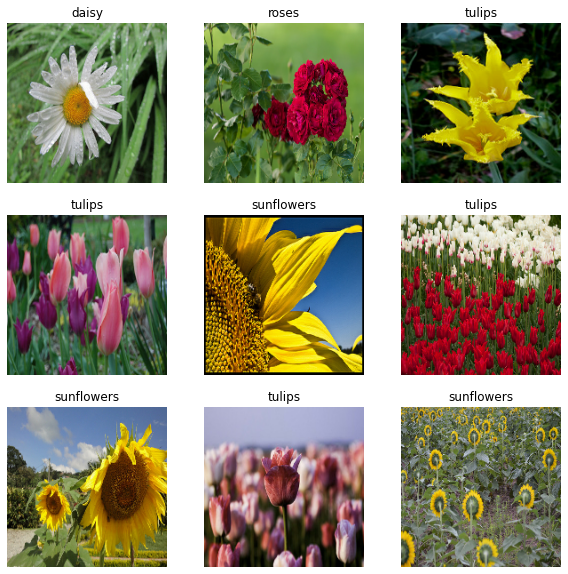

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [12]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(128, 180, 180, 3)
(128,)


In [13]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [14]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    # layers.RandomContrast(0.05),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

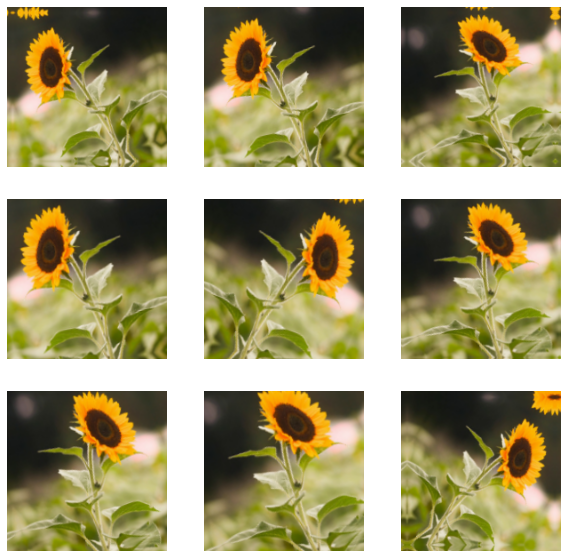

In [15]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [16]:
num_classes = len(class_names)

inputs = tf.keras.Input(shape=(img_height, img_width, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255, input_shape=(img_height, img_width, 3))(x)
x = layers.Conv2D(16, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(16, 3, padding='same', activation='relu')(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = layers.MaxPooling2D()(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation='relu')(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

In [17]:
base_learning_rate = 1e-4
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [18]:
# model.build(input_shape)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                             

In [19]:
epochs=100
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, batch_size=256)

Epoch 1/100
15/15 [==============================] - 18s 452ms/step - loss: 1.5638 - accuracy: 0.2726 - val_loss: 1.5508 - val_accuracy: 0.3600
Epoch 2/100
15/15 [==============================] - 3s 190ms/step - loss: 1.5121 - accuracy: 0.3631 - val_loss: 1.4798 - val_accuracy: 0.3267
Epoch 3/100
15/15 [==============================] - 3s 180ms/step - loss: 1.4096 - accuracy: 0.4087 - val_loss: 1.3158 - val_accuracy: 0.4600
Epoch 4/100
15/15 [==============================] - 3s 191ms/step - loss: 1.3170 - accuracy: 0.4536 - val_loss: 1.2025 - val_accuracy: 0.5089
Epoch 5/100
15/15 [==============================] - 3s 180ms/step - loss: 1.1815 - accuracy: 0.5369 - val_loss: 1.0304 - val_accuracy: 0.5733
Epoch 6/100
15/15 [==============================] - 3s 182ms/step - loss: 1.0446 - accuracy: 0.5919 - val_loss: 1.1143 - val_accuracy: 0.5533
Epoch 7/100
15/15 [==============================] - 3s 181ms/step - loss: 1.0446 - accuracy: 0.5708 - val_loss: 0.9585 - val_accuracy: 0.602

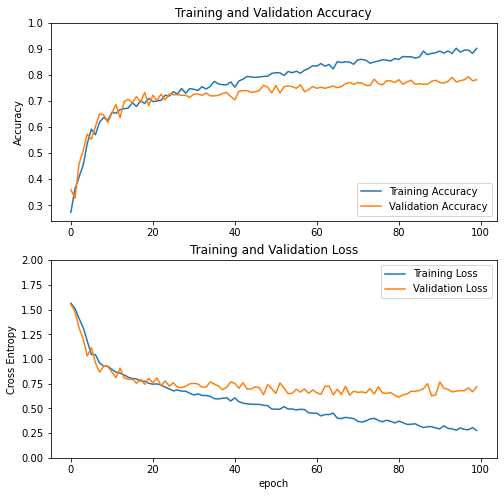

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [21]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

131072/117948 [=================================] - 0s 0us/step
This image most likely belongs to sunflowers with a 39.89 percent confidence.


In [22]:
loss, accuracy = model.evaluate(val_ds)

4/4 [==============================] - 0s 58ms/step - loss: 0.7188 - accuracy: 0.7822


In [23]:
y_pred = model.predict(val_ds)
predicted_categories = tf.argmax(y_pred, axis=1)
true_categories = tf.concat([y for x, y in val_ds], axis=0)

In [24]:
from sklearn.metrics import classification_report, confusion_matrix

In [25]:
print(classification_report(predicted_categories, true_categories, target_names=class_names))

              precision    recall  f1-score   support

       daisy       0.86      0.89      0.87        96
   dandelion       0.67      0.78      0.72        41
       roses       0.59      0.78      0.67        72
  sunflowers       0.91      0.75      0.83       113
      tulips       0.82      0.73      0.77       128

    accuracy                           0.78       450
   macro avg       0.77      0.79      0.77       450
weighted avg       0.80      0.78      0.79       450



In [26]:
conf_matrix = confusion_matrix(predicted_categories, true_categories)
print(conf_matrix)

[[85  1  4  1  5]
 [ 1 32  2  4  2]
 [ 6  0 56  2  8]
 [ 3 13  6 85  6]
 [ 4  2 27  1 94]]


In [27]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

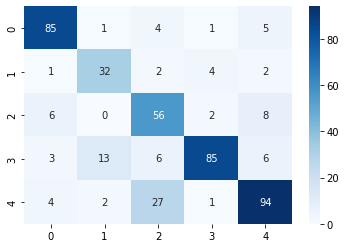

In [28]:
import seaborn as sns
sns.heatmap(conf_matrix, annot=True, cmap='Blues')

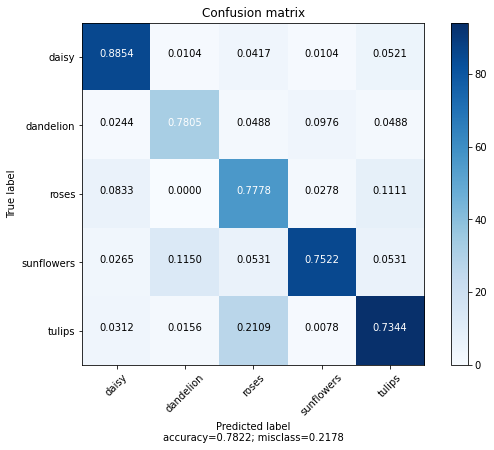

In [29]:
plot_confusion_matrix(conf_matrix, 
                      target_names=class_names,
                      normalize=True)

In [30]:
def predict_from_folder(directory):
  builder = tfds.ImageFolder(directory)
  ds = builder.as_dataset()
  pred = model.predict(val_ds)
  pred = tf.argmax(pred, axis=1)
  pred = pred.numpy()
  predicted_categories = []
  for i in pred:
    predicted_categories.append(class_names[i])
  
  return predicted_categories

In [31]:
labels = predict_from_folder('/content/dataset/flower_photos_selected/daisy')

In [32]:
print(labels)

['daisy', 'sunflowers', 'sunflowers', 'tulips', 'sunflowers', 'tulips', 'sunflowers', 'sunflowers', 'daisy', 'roses', 'daisy', 'daisy', 'sunflowers', 'roses', 'tulips', 'daisy', 'sunflowers', 'tulips', 'tulips', 'roses', 'tulips', 'tulips', 'dandelion', 'tulips', 'daisy', 'tulips', 'daisy', 'tulips', 'daisy', 'tulips', 'daisy', 'sunflowers', 'daisy', 'dandelion', 'sunflowers', 'dandelion', 'tulips', 'sunflowers', 'tulips', 'tulips', 'daisy', 'daisy', 'roses', 'roses', 'sunflowers', 'sunflowers', 'sunflowers', 'sunflowers', 'roses', 'tulips', 'daisy', 'sunflowers', 'tulips', 'roses', 'sunflowers', 'sunflowers', 'sunflowers', 'roses', 'tulips', 'daisy', 'roses', 'tulips', 'sunflowers', 'sunflowers', 'tulips', 'tulips', 'daisy', 'daisy', 'daisy', 'roses', 'roses', 'dandelion', 'sunflowers', 'tulips', 'daisy', 'roses', 'sunflowers', 'daisy', 'sunflowers', 'roses', 'tulips', 'tulips', 'roses', 'dandelion', 'daisy', 'sunflowers', 'tulips', 'roses', 'tulips', 'tulips', 'daisy', 'roses', 'tuli